## Basic information
#### frame of thickness is 0.084 mm


#### Read TIFF image stack

In [1]:
from PIL import Image
import numpy as np

# Read TIFF
img = Image.open("/Users/harrysong/Desktop/agriculture/tiff/020150.tiff")

frames = []
try:
    while True:
        frame = np.array(img.convert("L"))  # grayscale
        frames.append(frame)
        img.seek(img.tell() + 1)
except EOFError:
    pass  # End of file reached

print(f"total {len(frames)} frames")


total 2760 frames


#### 在每帧中检测圆形（麦秆）

In [2]:
import cv2
import numpy as np

def detect_stalk_circle(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # 提升对比度
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    # 高斯模糊（比中值模糊更适合平滑边缘）
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # 圆检测
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2,
                               minDist=20, param1=50, param2=20,
                               minRadius=15, maxRadius=35)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        output = frame.copy()
        for i in circles[0, :]:
            # 可视化圆
            cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)
        cv2.imshow("Detected Circle", output)
        cv2.waitKey(0)
        return True
    return False


#### 找出麦秆开始和结束的帧

In [ ]:
start_frame = None
end_frame = None

for i, frame in enumerate(frames):
    # Convert grayscale frame to BGR (3-channel) for processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    if detect_stalk_circle(frame_rgb):
        if start_frame is None:
            start_frame = i
        end_frame = i  # 每次检测到都更新结束帧

if start_frame is not None and end_frame is not None:
    print(f"麦秆从第 {start_frame} 帧到第 {end_frame} 帧")
else:
    print("未检测到麦秆圆形")



#### 质心追踪

TIFF shape: (2760, 406, 416)


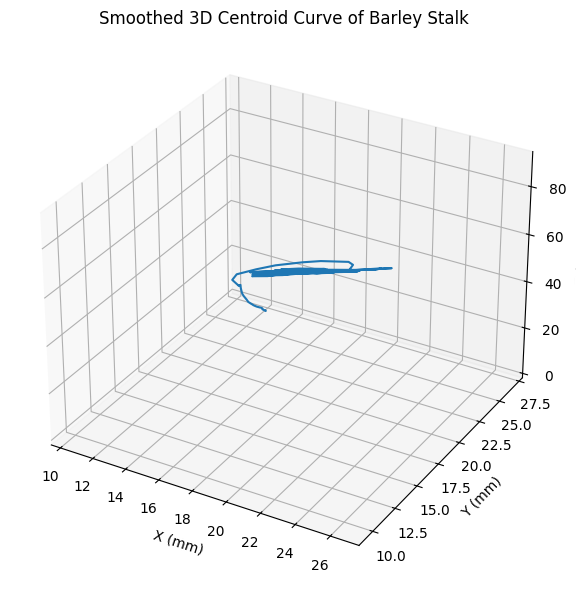

In [3]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

# 参数
start_frame = 1496
end_frame = 2597
pixel_spacing = 0.084  # mm
z_spacing = 1.0        # CT 间距，单位 mm
min_area = 200         # 噪声面积过滤阈值（可调）

# 载入 tiff 图像堆栈
stack = tifffile.imread("/Users/harrysong/Desktop/agriculture/tiff/020150.tiff")
print(f"TIFF shape: {stack.shape}")  # (num_frames, H, W)

centroids = []

# 遍历所有帧
for i in range(start_frame, end_frame + 1):
    frame = stack[i]

    # CLAHE 增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(frame)

    # Gamma 校正（增强暗部对比度）
    gamma = 1.5
    gamma_corrected = np.power(enhanced / 255.0, gamma) * 255
    enhanced = gamma_corrected.astype(np.uint8)

    # 二值化
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 轮廓提取
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 面积过滤 + 质心提取
    valid = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    if valid:
        largest = max(valid, key=cv2.contourArea)
        M = cv2.moments(largest)
        if M["m00"] != 0:
            cx = M["m10"] / M["m00"]
            cy = M["m01"] / M["m00"]
            cz = (i - start_frame) * z_spacing
            centroids.append([cx, cy, cz])

centroids = np.array(centroids)

# 平滑处理（可选）
if centroids.shape[0] >= 11:
    for axis in range(3):  # x, y, z
        centroids[:, axis] = savgol_filter(centroids[:, axis], window_length=11, polyorder=3)

# 转换为 mm 单位
centroids_mm = centroids * np.array([pixel_spacing, pixel_spacing, pixel_spacing])

# 3D 可视化
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2])
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
plt.title("Smoothed 3D Centroid Curve of Barley Stalk")
plt.tight_layout()
plt.show()
